In [4]:
from google.colab import drive
# Mount Google Drive to access the dataset
# This allows you to access your Google Drive files in Colab

drive.mount('/content/drive')
!pip install --upgrade tensorflow tensorboard

import os
import torch
import torchvision
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorfl

In [5]:
# check the classes present in the dataset:
data_dir  = '/content/drive/My Drive/final_project/dataset/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['.DS_Store', 'metal', 'cardboard', 'paper', 'trash', 'glass', 'plastic']


In [6]:
# transformations and preprocess data

transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
dataset = ImageFolder(data_dir, transform = transformations)

In [7]:
# 2527 images in dataset in total
print(len(dataset))

2527


In [8]:
# helper function to check the image and corresponding label

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


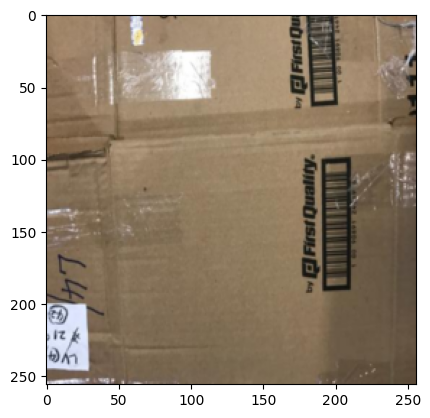

In [9]:
img, label = dataset[10]
show_sample(img, label)

In [10]:
# loading and splitting data

random_seed = 42
torch.manual_seed(random_seed)

In [11]:
# 70% for train, 15% for validation, 15% for test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# random split dataset
train_ds, val_ds, test_ds = random_split(dataset,
                                         [train_size, val_size, test_size])

len(train_ds), len(val_ds), len(test_ds)

(1768, 379, 380)

In [12]:
batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2, shuffle=False)

In [13]:
# a helper function to visualize batches

def show_batch(dataloader):
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

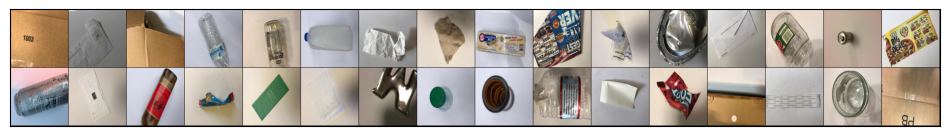

In [14]:
show_batch(train_loader)

### Model Base

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
# we use ResNet50 for classification

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # pre-trained model
        self.network = models.resnet50(weights='DEFAULT')
        # replace the last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.relu(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s] 


### Porting to GPU

In [51]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [52]:
device = get_default_device()
device

device(type='cuda')

In [53]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### Training Model

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        # Move batch to the same device as model
        batch = to_device(batch, device)
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(log_dir='runs')

    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            # Move batch to the same device as model
            batch = to_device(batch, device)
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # Log training loss to TensorBoard
        writer.add_scalar("Train/Loss", result['train_loss'], epoch)

    writer.close()
    return history


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = to_device(ResNet(), device)

In [22]:
evaluate(model, val_loader)

In [23]:
# training model

num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4593, val_loss: 1.0849, val_acc: 0.6431
Epoch 2: train_loss: 0.6869, val_loss: 0.6090, val_acc: 0.8259
Epoch 3: train_loss: 0.3229, val_loss: 0.4541, val_acc: 0.8650
Epoch 4: train_loss: 0.1832, val_loss: 0.3974, val_acc: 0.8682
Epoch 5: train_loss: 0.1087, val_loss: 0.3296, val_acc: 0.8891
Epoch 6: train_loss: 0.0563, val_loss: 0.2879, val_acc: 0.9049
Epoch 7: train_loss: 0.0459, val_loss: 0.3035, val_acc: 0.9099
Epoch 8: train_loss: 0.0419, val_loss: 0.2829, val_acc: 0.9106
Epoch 9: train_loss: 0.0306, val_loss: 0.3138, val_acc: 0.9071
Epoch 10: train_loss: 0.0245, val_loss: 0.3083, val_acc: 0.9206


In [38]:
torch.save(model, 'garbage_classification_model.pth')

In [40]:
import torch

# Load the model
try:
    loaded_model = torch.load('garbage_classification_model.pth')
    print("The model has been successfully loaded.")
except FileNotFoundError:
    print("Model file not found. The save operation might have failed.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")


The model has been successfully loaded.


<ipython-input-40-cff844382065>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('garbage_classification_model.pth')


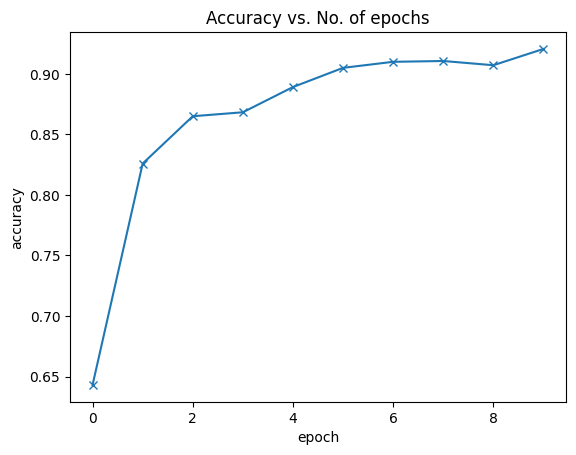

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

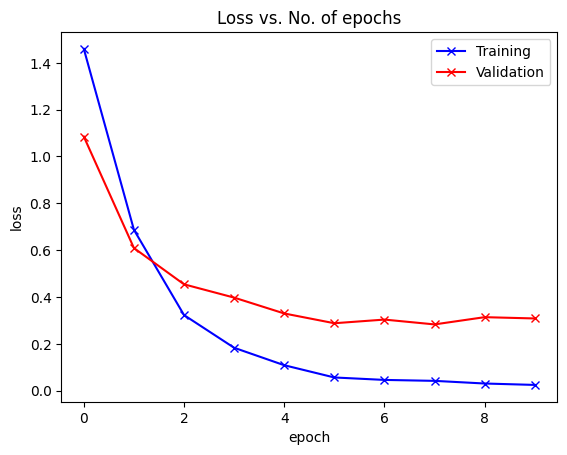

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

### Visualizing Predictions

In [47]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: plastic


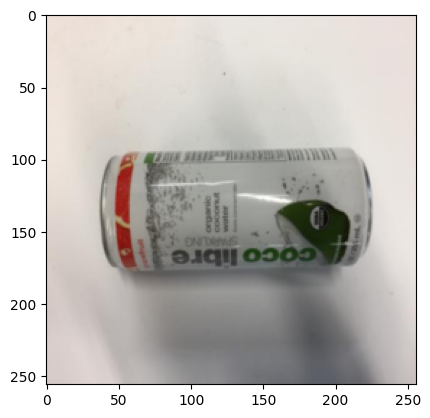

In [48]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: cardboard , Predicted: glass


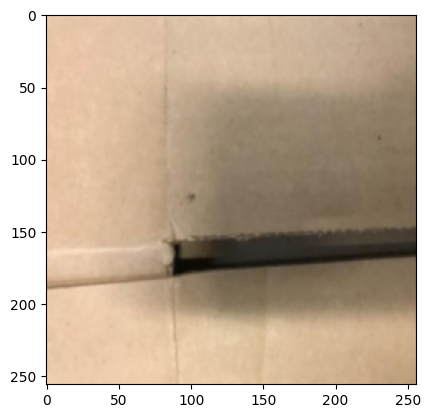

In [49]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: plastic


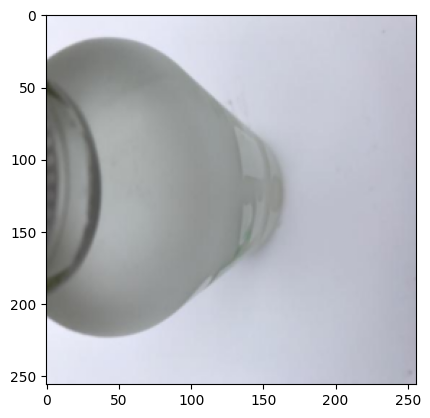

In [50]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [39]:
!pip install --upgrade gradio

import gradio as gr
import torch
from torchvision import transforms
from PIL import Image

# 假设你的模型是一个PyTorch模型
model = torch.load('garbage_classification_model.pth')
model.eval()  # 设置为评估模式

# 定义图像预处理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # 根据模型的输入大小进行调整
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义预测函数
def classify_garbage(image):
    # 图像预处理
    img_tensor = preprocess(image).unsqueeze(0)  # 添加batch维度
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    # 假设类别标签是垃圾分类标签的列表
    categories = ['Plastic', 'Paper', 'Metal', 'Glass', 'Organic']  # 根据你的模型标签定义
    return categories[predicted.item()]

# 使用Gradio创建接口
iface = gr.Interface(
    fn=classify_garbage,
    inputs=gr.Image(type="pil"),  # Removed source="webcam"
    outputs="text",
    title="Garbage Classification",
    description="Upload or capture an image, and the system will classify the type of garbage.",
)



# 启动Gradio应用
iface.launch()


<ipython-input-39-a3a0b4c7cf06>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('garbage_classification_model.pth')


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://880b586fd98c4eeda4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
